# Name: Nalet Meinen¶

# Assignment 2 ATML 2020
## Classification with limited data
ImageNet is a well known dataset with 1000 image classes. We will be working on a subset of the dataset (60k images, 100 classes, 600 images per class 80$\times$80 pixels, RGB) and train a model to classify an image into one of the 100 classes. The dataset is located under the "data" directory. Training and validation data splits are under "data/train" and "data/val" directories respectively. Both splits consist of 100 directories, each representing an object category.

In [0]:
import numpy as np
import time
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Sun Apr 19 15:14:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    48W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import os.path
if not os.path.isfile('data.zip'):
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r "/content/drive/My Drive/ATML/Assignments/Assignment2/data.zip" "data.zip"
    !unzip -qq data.zip

## Task 1. Implement ImageNetLimited class for data loading in datasets.py file

In [0]:
from PIL import Image
import glob
import torch
import os.path

class ImageNetLimited(torch.utils.data.Dataset):
    """ImageNet Limited dataset."""
    
    def __init__(self, root_dir, transform, instances=1,selected_classes=None):
        data = []

        for path in tqdm(glob.glob(root_dir + "/**/*")):
            target = int(os.path.basename(os.path.dirname(path)))

            if selected_classes != None and target not in selected_classes:
                continue

            _image = Image.open(path)
            
            for _ in range(instances):
                data.append((transform(_image),target))
        
        self.n = len(data)
        self.data = data

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.data[idx]
        

In [5]:
train_dir = 'data/train'
validation_dir = 'data/val'

_t_mean=[0.485, 0.456, 0.406]
_t_std=[0.229, 0.224, 0.225]

_transforms_train = transforms.Compose([
    transforms.RandomRotation([-45,45]),
    transforms.RandomCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

_transforms_val = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=_t_mean, std=_t_std)
])

selected_classes = None # [0,1,2,3,4,5,6,7,8,9]

train_dataset = ImageNetLimited(train_dir,_transforms_train,5,selected_classes=selected_classes)
val_dataset = ImageNetLimited(validation_dir,_transforms_val,selected_classes=selected_classes)

print("\n","Train dataset length:",len(train_dataset),"Validation dataset length:",len(val_dataset))

100%|██████████| 29855/29855 [00:18<00:00, 1649.12it/s]


 Train dataset length: 300000 Validation dataset length: 29855


## Task 2. CNN Architecture
Design and implement a Convolutional Neural Network architecture for image classification in a **ConvNet** class in the notebook. Some examples of popular classification models are: AlexNet, VGG, ResNet, ... Justify your design choices in the report. The input to your model must be an image of size $64 \times 64$ pixels.

In [0]:
class Block(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False), 
                nn.BatchNorm2d(planes)
            )

    def forward(self, input):
        output = nn.functional.relu(self.bn1(self.conv1(input)))
        output = self.bn2(self.conv2(output))
        output += self.shortcut(input)
        output = nn.functional.relu(output)
        return output

class ConvNet(nn.Module):

    def __init__(self, num_blocks):
        super(ConvNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        self.linear = nn.Linear(2048, 100)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(Block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, input):
        output = nn.functional.relu(self.bn1(self.conv1(input)))
        output = self.layer1(output)
        output = self.layer2(output)
        output = self.layer3(output)
        output = self.layer4(output)
        output = nn.functional.avg_pool2d(output, 4)
        output = torch.flatten(output, 1)
        output = self.linear(output)
        return nn.functional.log_softmax(output, dim=1)

## Task 3. Train Model
Implement training and evaluation code for your model. Choose an appropriate loss function and evaluate the model on the validation set using classification accuracy. You are not allowed to use a pre-trained model (must train from scratch on the provided data).<br>
<font color='red'>Your model should achieve an accuracy of at least 40.0% on the validation set (Model with performance smaller than 40.0% will result in 0 points for this task).</font><br>

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def train(model, train_loader, optimizer, loss_fn):
    '''
    Trains the model for one epoch
    '''
    model.train()
    losses = []
    n_correct = 0
    for iteration, (images, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        n_correct += torch.sum(output.argmax(1) == labels).item()
    accuracy = 100.0 * n_correct / len(train_loader.dataset)
    return np.mean(np.array(losses)), accuracy
            
def test(model, test_loader, loss_fn):
    '''
    Tests the model on data from test_loader
    '''
    model.eval()
    test_loss = 0
    n_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = loss_fn(output, labels)
            test_loss += loss.item()
            n_correct += torch.sum(output.argmax(1) == labels).item()

    average_loss = test_loss / len(test_loader)
    accuracy = 100.0 * n_correct / len(test_loader.dataset)
    return average_loss, accuracy


def fit(taskname,train_dataloader, val_dataloader, num_blocks, optimizer, loss_fn, n_epochs, **optimizer_params):
    model = ConvNet(num_blocks)
    model = model.to(device)

    optimizer = optimizer(model.parameters(), **optimizer_params)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    last_val_accuracies = 0
    best_epoch = 1

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
        val_loss, val_accuracy = test(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        time.sleep(0.250) # needed for tqdm
        print("""Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}""".format(
                        epoch+1, n_epochs, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1]))
        time.sleep(0.250)
        if val_accuracies[-1] > last_val_accuracies:
            torch.save(model.state_dict(), str(taskname)+".pht")
            best_epoch = epoch+1
            last_val_accuracies = val_accuracies[-1]

        best_model = ConvNet(num_blocks)
        best_model = best_model.to(device)
        best_model.load_state_dict(torch.load(str(taskname)+".pht"))

    return train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch

def plot_results(train_results, test_dataloader, val_dataloader):
    train_losses, train_accuracies, val_losses, val_accuracies, loss_fn, best_model, best_epoch = train_results

    fig, axs = plt.subplots(1, 2,figsize=(15, 4))

    axs[0].plot(np.arange(len(train_losses)), train_losses)
    axs[0].plot(np.arange(len(val_losses)), val_losses)
    axs[0].legend(['train_loss', 'val_loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss value')
    axs[0].set_title('Train/val loss');

    axs[1].plot(np.arange(len(train_accuracies)), train_accuracies)
    axs[1].plot(np.arange(len(val_accuracies)), val_accuracies)
    axs[1].legend(['train_acc', 'val_acc'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Train/val accuracy');

    plt.show()

    m_loss, accuracy = test(best_model, val_dataloader, loss_fn)
    print("Best Epoch:", best_epoch, "Average loss:", m_loss, "Accuracy:", accuracy)
    torch.cuda.empty_cache()

100%|██████████| 586/586 [08:34<00:00,  1.14it/s]


Epoch 1/10: train_loss: 3.3827, train_accuracy: 18.1747, val_loss: 3.2366, val_accuracy: 21.9863


100%|██████████| 586/586 [08:34<00:00,  1.14it/s]


Epoch 2/10: train_loss: 2.4880, train_accuracy: 34.5513, val_loss: 2.7087, val_accuracy: 31.2443


100%|██████████| 586/586 [08:34<00:00,  1.14it/s]


Epoch 3/10: train_loss: 2.0406, train_accuracy: 44.3347, val_loss: 2.4829, val_accuracy: 35.7260


100%|██████████| 586/586 [08:34<00:00,  1.14it/s]


Epoch 4/10: train_loss: 1.7187, train_accuracy: 51.9950, val_loss: 2.3534, val_accuracy: 40.8776


100%|██████████| 586/586 [08:35<00:00,  1.14it/s]


Epoch 5/10: train_loss: 1.4569, train_accuracy: 58.5200, val_loss: 2.1933, val_accuracy: 43.4534


100%|██████████| 586/586 [08:35<00:00,  1.14it/s]


Epoch 6/10: train_loss: 1.2216, train_accuracy: 64.6750, val_loss: 2.3093, val_accuracy: 42.0600


100%|██████████| 586/586 [08:35<00:00,  1.14it/s]


Epoch 7/10: train_loss: 0.9990, train_accuracy: 70.5617, val_loss: 2.3303, val_accuracy: 44.1635


100%|██████████| 586/586 [08:34<00:00,  1.14it/s]


Epoch 8/10: train_loss: 0.7894, train_accuracy: 76.6097, val_loss: 2.3411, val_accuracy: 44.9941


100%|██████████| 586/586 [08:35<00:00,  1.14it/s]


Epoch 9/10: train_loss: 0.6063, train_accuracy: 81.9947, val_loss: 2.2746, val_accuracy: 46.6019


100%|██████████| 586/586 [08:34<00:00,  1.14it/s]


Epoch 10/10: train_loss: 0.4450, train_accuracy: 87.0333, val_loss: 2.5251, val_accuracy: 45.2521


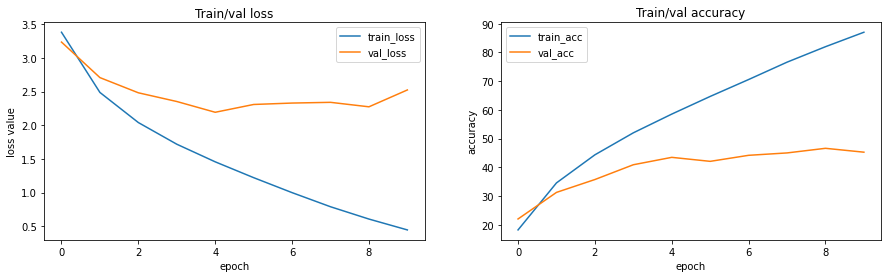

Best Epoch: 9 Average loss: 2.2745529918347374 Accuracy: 46.60190922793502
CPU times: user 52min 2s, sys: 36min 59s, total: 1h 29min 2s
Wall time: 1h 29min 12s


In [8]:
%%time
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.NLLLoss()
task3_results = fit("task3", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.02, momentum=0.9, weight_decay=5e-4)
plot_results(task3_results, train_dataloader, val_dataloader)

```
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 1/10: train_loss: 3.3827, train_accuracy: 18.1747, val_loss: 3.2366, val_accuracy: 21.9863
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 2/10: train_loss: 2.4880, train_accuracy: 34.5513, val_loss: 2.7087, val_accuracy: 31.2443
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 3/10: train_loss: 2.0406, train_accuracy: 44.3347, val_loss: 2.4829, val_accuracy: 35.7260
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 4/10: train_loss: 1.7187, train_accuracy: 51.9950, val_loss: 2.3534, val_accuracy: 40.8776
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 5/10: train_loss: 1.4569, train_accuracy: 58.5200, val_loss: 2.1933, val_accuracy: 43.4534
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 6/10: train_loss: 1.2216, train_accuracy: 64.6750, val_loss: 2.3093, val_accuracy: 42.0600
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 7/10: train_loss: 0.9990, train_accuracy: 70.5617, val_loss: 2.3303, val_accuracy: 44.1635
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 8/10: train_loss: 0.7894, train_accuracy: 76.6097, val_loss: 2.3411, val_accuracy: 44.9941
100%|██████████| 586/586 [08:35<00:00,  1.14it/s]
Epoch 9/10: train_loss: 0.6063, train_accuracy: 81.9947, val_loss: 2.2746, val_accuracy: 46.6019
100%|██████████| 586/586 [08:34<00:00,  1.14it/s]
Epoch 10/10: train_loss: 0.4450, train_accuracy: 87.0333, val_loss: 2.5251, val_accuracy: 45.2521

Best Epoch: 9 Average loss: 2.2745529918347374 Accuracy: 46.60190922793502
CPU times: user 52min 2s, sys: 36min 59s, total: 1h 29min 2s
Wall time: 1h 29min 12s
```
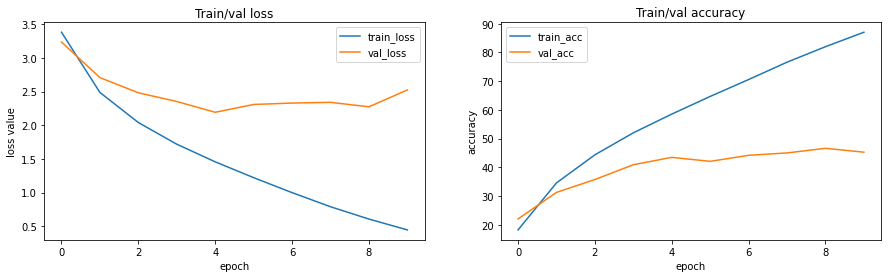

## Task 4. Ablations
Try to find the best performing model by tuning the model design and hyper-parameters on the validation set. Perform ablation experiments to illustrate the effect of the most important hyper-parameters. Some examples of ablations: training parameters (e.g., optimizer, learning rates, batch size), network architecture (e.g., number of layers, number of units, activation function, normalization layers), model regularization (e.g., data augmentation, dropout, weight decay, early stopping), test-time augmentation, etc...  <br>**Perform at least 5 ablations and report the performance of each on the validation set.**

### Ablation 1: Learing Rate

In [0]:
%%time
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.NLLLoss()
ablation1_results = fit("ablation1", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.01, momentum=0.9, weight_decay=5e-4)
plot_results(ablation1_results, train_dataloader, val_dataloader)

 44%|████▍     | 257/586 [03:45<04:48,  1.14it/s]

The Learning Rate is an important parameter of the Gradient Descent. The rate helps to control the change of weights for our network to the loss of the Gradient Descent. It is one of the most imporant parameters. Playing with it can have a large effect as seen in this ablation. With the change of the rate by factor 10, the result is different by a even larger factor. With a learning rate to large, we are making too huge steps and can miss a local optima, as shown in this ablation 1.

### Ablation 2: Batch Size

In [0]:
%%time
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
optimizer = torch.optim.SGD
n_epochs = 10
loss_fn = nn.NLLLoss()
ablation1_results = fit("ablation1", train_dataloader, val_dataloader, [2, 2, 2, 2], optimizer, loss_fn, n_epochs, lr=0.02, momentum=0.9, weight_decay=5e-4)
plot_results(ablation1_results, train_dataloader, val_dataloader)

The Learning Rate is an important parameter of the Gradient Descent. The rate helps to control the change of weights for our network to the loss of the Gradient Descent. It is one of the most imporant parameters. Playing with it can have a large effect as seen in this ablation. With the change of the rate by factor 10, the result is different by a large factor. With a learning rate to large, we are making too huge steps and can miss a local optima, as shown in this ablation 1.

## Task 5. Model Errors
Evaluate the trained model on the validation set and plot 10 random mistakes that your model made.

In [0]:
# write your code

## Task 6. Competition time!
Read the images from "data/test" folder. There are no labels for these images. Run your best model on these images and save the image IDs (names) and predicted label in a file LastName.csv. You will receive a link via email to upload the CSV file to  an online system which will give you the score of your model on the held-out test set. Top 5 students with at least 40% classification accuracy will obtain bonus points.

In [0]:
# write your code